In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
data = pd.read_csv("housing.csv")
#rozdelenie predikovanej hodnoty a zvyšku
target= data['median_house_value']
data=data.drop(columns=['median_house_value'])
#upravenie column ocean_proximity aby sa dala dať do torchu
data['ocean_proximity'] = data['ocean_proximity'].astype('category')
data['ocean_proximity'] = data['ocean_proximity'].cat.codes

data.describe()
data['total_bedrooms']=data['total_bedrooms'].fillna(data['total_bedrooms'].mean())

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

x_train,x_test,y_train,y_test = train_test_split(data_scaled,target,test_size=0.2 , random_state=42)
y_train=y_train.values
y_test=y_test.values

In [2]:
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
train_dataset = HousingDataset(x_train, y_train_scaled)
test_dataset = HousingDataset(x_test, y_test_scaled)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
class HousingModel(nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        self.fc1 = nn.Linear(in_features=x_train.shape[1], out_features=64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x)) 
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
criterion = nn.MSELoss()


In [4]:
def model_evaluation_meow(model):
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for inputs, targets in test_loader:
            outputs = model(inputs)
            y_pred.append(outputs.squeeze().numpy())
            y_true.append(targets.numpy())
        
        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        
        mse = np.mean((y_pred - y_true) ** 2)
        print(f'Test MSE: {mse}')


Epoch_num :10/100, Loss: 0.8415160131777903
Epoch_num :20/100, Loss: 0.40028486516355544
Epoch_num :30/100, Loss: 0.3252989674030348
Epoch_num :40/100, Loss: 0.297163716871147
Epoch_num :50/100, Loss: 0.28433174120132315
Epoch_num :60/100, Loss: 0.27550085492489873
Epoch_num :70/100, Loss: 0.26829962539233904
Epoch_num :80/100, Loss: 0.26275793012491494
Epoch_num :90/100, Loss: 0.25832351554156274
Epoch_num :100/100, Loss: 0.2546384286915147


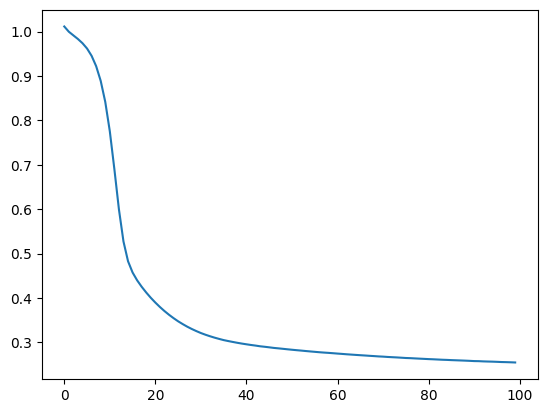

Test MSE: 0.2710162401199341


In [5]:
import matplotlib.pyplot as plt
def run_model(optimizer,model):
    num_epochs = 100
    epoch_array=[]
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)  
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        if (epoch+1)%10==0:
            print(f'Epoch_num :{epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
        epoch_array.append(running_loss/len(train_loader))
    
    plt.plot(epoch_array)
    plt.show()
    model_evaluation_meow(model)
    return epoch_array[-1]
sgd_model = HousingModel()
sgd_optimizer = optim.SGD(sgd_model.parameters(), lr=0.001)    
sgd_result=run_model(sgd_optimizer,sgd_model)


Epoch_num :10/100, Loss: 0.26702188301918117
Epoch_num :20/100, Loss: 0.2420100295670735
Epoch_num :30/100, Loss: 0.22800589445256447
Epoch_num :40/100, Loss: 0.21748973966337914
Epoch_num :50/100, Loss: 0.20722923603977345
Epoch_num :60/100, Loss: 0.20110791078371595
Epoch_num :70/100, Loss: 0.19806276902902958
Epoch_num :80/100, Loss: 0.1891488058044929
Epoch_num :90/100, Loss: 0.18596485664331636
Epoch_num :100/100, Loss: 0.18268015128813048


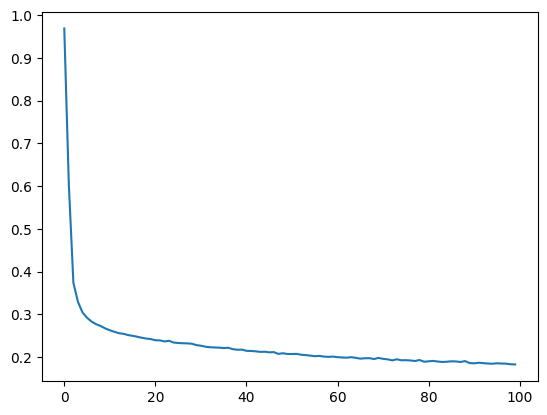

Test MSE: 0.2151893824338913


In [6]:
sgd_momentum_model = HousingModel()
sgd_momentum_optimizer = optim.SGD(sgd_momentum_model.parameters(), lr=0.001, momentum=0.9)
sgd_momentum_result=run_model(sgd_momentum_optimizer,sgd_momentum_model)

Epoch_num :10/100, Loss: 0.2083557121917721
Epoch_num :20/100, Loss: 0.18540837806324625
Epoch_num :30/100, Loss: 0.17368788638895796
Epoch_num :40/100, Loss: 0.16307092538868734
Epoch_num :50/100, Loss: 0.15088062708865302
Epoch_num :60/100, Loss: 0.14320006851078004
Epoch_num :70/100, Loss: 0.13525433620336905
Epoch_num :80/100, Loss: 0.12207691738194273
Epoch_num :90/100, Loss: 0.1154995469535275
Epoch_num :100/100, Loss: 0.11028172166714835


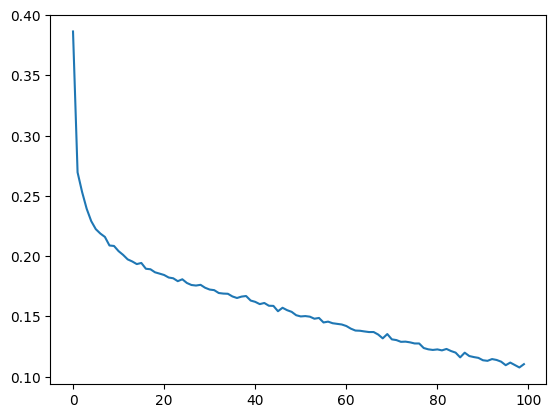

Test MSE: 0.22105969488620758


In [7]:
adam_model = HousingModel()
adam_optimizer = optim.Adam(adam_model.parameters(), lr=0.001)
adam_result=run_model(adam_optimizer,adam_model)

In [8]:
print(min(adam_result,sgd_momentum_result,sgd_result))

0.11028172166714835


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  int8   
dtypes: float64(8), int8(1)
memory usage: 1.3 MB


In [10]:
class LinearLayer:
    def __init__(self, input_dim, output_dim):
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.weights = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.grad_weights = None
        self.grad_bias = None
        self.velocity_weights = np.zeros_like(self.weights)
        self.velocity_bias = np.zeros_like(self.bias)

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def update(self, lr, momentum=None):
        if self.grad_weights is None or self.grad_bias is None:
            raise ValueError("Gradients have not been computed yet. Call backward() before update().")
        
        if momentum is None:
            self.weights -= lr * self.grad_weights
            self.bias -= lr * self.grad_bias
        else:
            self.velocity_weights = momentum * self.velocity_weights - lr * self.grad_weights
            self.weights += self.velocity_weights

            self.velocity_bias = momentum * self.velocity_bias - lr * self.grad_bias
            self.bias += self.velocity_bias
'''     
class NeuralNetwork:
    def __init__(self):
        self.layer1 = LinearLayer(2, 4) 
        self.layer2 = LinearLayer(4, 1)

    def forward(self, x):
        self.layer1_output = self.layer1.forward(x)
        self.layer1_output_activated = np.tanh(self.layer1_output)
        self.layer2_output = self.layer2.forward(self.layer1_output_activated)
        return self.layer2_output

    def backward(self, grad_output):
        # Backward pass: compute gradients
        grad_layer2 = grad_output * (1 - np.tanh(self.layer2_output) ** 2) 
        grad_layer1 = self.layer2.backward(grad_layer2)
        grad_layer1_activated = grad_layer1 * (1 - np.tanh(self.layer1_output) ** 2) 
        self.layer1.backward(grad_layer1_activated)

    def update(self, lr, momentum=0.9):
        self.layer1.update(lr, momentum)
        self.layer2.update(lr, momentum)'''

class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)

class Sigmoid:
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output):
        return grad_output * (self.output * (1 - self.output))

class Tanh:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output

    def backward(self, grad_output):
        return grad_output * (1 - self.output**2)
class MSELoss:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self):
        return 2 * (self.y_pred - self.y_true) / self.y_true.size
class SequentialModel:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def update(self, lr, momentum=None):
        for layer in self.layers:
            if hasattr(layer, 'update'):
                layer.update(lr, momentum)



class LinearLayerWithMomentum(LinearLayer):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim, output_dim)
    def update(self, lr, momentum=0.9):
        if self.grad_weights is None or self.grad_bias is None:
            raise ValueError("Gradients have not been computed yet. Call backward() before update().")
        
        self.velocity_weights = momentum * self.velocity_weights - lr * self.grad_weights
        self.weights += self.velocity_weights
        self.velocity_bias = momentum * self.velocity_bias - lr * self.grad_bias
        self.bias += self.velocity_bias


Epoch 50, Loss: 0.04386839259838642
Epoch 100, Loss: 0.0010776517526109998
Epoch 150, Loss: 0.000630095238637452
Epoch 200, Loss: 0.0004593280542343336
Epoch 250, Loss: 0.0003611223136909411
Epoch 300, Loss: 0.00029719770005568304
Epoch 350, Loss: 0.0002522753459805062
Epoch 400, Loss: 0.00021899122979492696
Epoch 450, Loss: 0.0001933521073512007
Epoch 500, Loss: 0.00017300351885145678


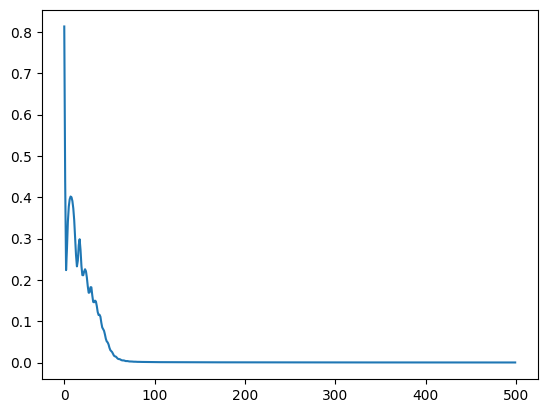

Test Loss: 0.00017263933851757035


In [11]:

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

model = SequentialModel([
    LinearLayer(X.shape[1], 4), 
    Tanh(),              
    LinearLayer(4, 1),           
    Tanh()                      
])
loss_fn = MSELoss()

lr = 0.1  
num_epochs = 500
plot_data = []

for epoch in range(num_epochs):
    y_pred = model.forward(X)  
    loss = loss_fn.forward(y_pred, y)
    
    grad_loss = loss_fn.backward()
    model.backward(grad_loss)
    momentum = 0.9  
    model.update(lr, momentum)
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss}')
    plot_data.append(loss)

plt.plot(plot_data)
plt.show()

y_pred = model.forward(X) 
test_loss = loss_fn.forward(y_pred, y)
print(f'Test Loss: {test_loss}')
